In [165]:
import os
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [166]:
def read_data(file_path):
    # Open the file
    with open(file_path, 'r') as file:  # Use 'with' for automatic file closure

        # Split the text data into lines and remove extra whitespace
        lines = [line.strip() for line in file if line.strip()] 

        # Create a list to store data rows
        data = []

        # Process each line
        for line in lines:
            # Split the values in the line based on multiple spaces
            values = line.split()  
            
            # Convert values to floats
            values = [abs(float(val)) for val in values]

            # Add the row to the data list
            data.append(values)

    # Create a Pandas DataFrame
    column_names = [
        'absolute angle of inclination', 'angle of inclination', 'number of electrodes',
        'voltage magnitude', 'voltage frequency', 'electrode dimension',
        'x pitch', 'number of phases', 'grain mass density',
        'mesh size', 'gravity', 'phase shift', 'time step',
        'maximum classified radius', 'distance between dust generation and first electrode',
        'grain number density', 'yield'
    ]

    df = pd.DataFrame(data, columns=column_names)

    return df

def read_dataset_folder(folder_path):
    # Get a list of all files in the folder
    file_list = [f for f in os.listdir(folder_path) if f.endswith('.txt')] 

    # Create an empty list to store DataFrames
    all_dataframes = []

    # Read each file and append its DataFrame to the list
    for file_name in file_list:
        file_path = os.path.join(folder_path, file_name)
        df = read_data(file_path)
        all_dataframes.append(df)

    # Concatenate all DataFrames into a single DataFrame
    concatenated_df = pd.concat(all_dataframes, ignore_index=True)

    concatenated_df = concatenated_df.fillna(concatenated_df.mean())

    return concatenated_df

In [167]:
Folder_name = "Dataset"
data = read_dataset_folder(Folder_name)
data

,absolute angle of inclination,angle of inclination,number of electrodes,voltage magnitude,voltage frequency,electrode dimension,x pitch,number of phases,grain mass density,mesh size,gravity,phase shift,time step,maximum classified radius,distance between dust generation and first electrode,grain number density,yield
0,335.0,25.0,4.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.014511,1.0,3.738749
1,335.0,25.0,6.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.015185,1.0,2.602313
2,335.0,25.0,8.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.015858,1.0,2.719417
3,335.0,25.0,10.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.016532,1.0,1.865867
4,335.0,25.0,4.0,500.0,5.0,4.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.014011,1.0,6.512353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15848,50.0,50.0,4.0,2000.0,20.0,5.0,35.0,4.0,4000.0,0.001,12.0,90.0,0.005,0.00001,0.125134,1.0,1.085980
15849,50.0,50.0,6.0,2000.0,20.0,5.0,35.0,4.0,4000.0,0.001,12.0,90.0,0.005,0.00001,0.208557,1.0,0.112520
15850,50.0,50.0,8.0,2000.0,20.0,5.0,35.0,4.0,4000.0,0.001,12.0,90.0,0.005,0.00001,0.291980,1.0,0.014352
15851,50.0,50.0,10.0,2000.0,20.0,5.0,35.0,4.0,4000.0,0.001,12.0,90.0,0.005,0.00001,0.375402,1.0,0.003888


In [168]:
yield_min = 0
yield_max = 30
# Define the number of bins
num_bins = 50
number_of_data_points = 1500
# Filter data to include only rows where the yield value is between yield_min and yield_max
filtered_data = data[(data['yield'] >= yield_min) & (data['yield'] <= yield_max)]

# Create bins
bins = np.linspace(yield_min, yield_max, num_bins + 1)

# Create an empty list to store the selected data
selected_data = []

# For each bin, randomly select number_of_data_points/num_bins datapoints
for i in range(num_bins):
    # Filter data to include only rows where the yield value is in the current bin
    bin_data = filtered_data[(filtered_data['yield'] >= bins[i]) & (filtered_data['yield'] < bins[i+1])]

    # Randomly select number_of_data_points/num_bins datapoints from the bin data
    bin_selected_data = bin_data.sample(n=number_of_data_points//num_bins, replace=False)

    # Add the selected data to the list
    selected_data.append(bin_selected_data)

# Concatenate all selected data into a single DataFrame
subset_data = pd.concat(selected_data, ignore_index=True)
data = subset_data

In [169]:
numeric_features = ['absolute angle of inclination', 'number of electrodes', 'electrode dimension',
                    'x pitch', 'distance between dust generation and first electrode', 'voltage magnitude',
                    'voltage frequency', 'grain mass density', 'gravity']

class CustomDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        row = self.data.iloc[index]
        features = row[numeric_features].values.astype(np.float32)
        target = row['yield'].astype(np.float32)
        return features, target

In [170]:
dataset = CustomDataset(data)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [176]:

class Net(nn.Module):
    def __init__(self, hidden_layer_size, input_size = len(numeric_features), dropout_prob=0):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_layer_size)
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_layer_size, hidden_layer_size)
        self.dropout2 = nn.Dropout(dropout_prob)
        self.fc3 = nn.Linear(hidden_layer_size, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout1(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout2(x)
        x = self.fc3(x)
        return x


In [177]:
epochs = 100
train_losses = []
val_losses = []
batch_size = 1
hidden_layer_size = 16

In [178]:
def rmse_loss(outputs, targets):
    return torch.sqrt(F.mse_loss(outputs, targets.unsqueeze(1)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

def to_device(data, device):
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


model = Net(hidden_layer_size).to(device)
model = model.float()
criterion = rmse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_dataset.to_device = to_device
val_dataset.to_device = to_device

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

Using cuda device


In [179]:
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)
    print(f'Epoch {epoch+1}, Train Loss: {train_loss:.6f}', end=" ")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    print(f'Test Loss: {val_loss:.6f}')

Epoch 1, Train Loss: 6.339935 Test Loss: 7.072900
Epoch 2, Train Loss: 5.841390 Test Loss: 5.879127
Epoch 3, Train Loss: 5.591891 Test Loss: 5.522903
Epoch 4, Train Loss: 5.297784 Test Loss: 5.678523
Epoch 5, Train Loss: 5.327687 Test Loss: 5.329255
Epoch 6, Train Loss: 5.241768 Test Loss: 5.620427
Epoch 7, Train Loss: 5.235527 Test Loss: 5.274977
Epoch 8, Train Loss: 5.185888 Test Loss: 5.438349
Epoch 9, Train Loss: 5.123442 Test Loss: 5.478640
Epoch 10, Train Loss: 5.076140 Test Loss: 5.232238
Epoch 11, Train Loss: 5.025886 Test Loss: 4.868133
Epoch 12, Train Loss: 4.933490 Test Loss: 5.181836
Epoch 13, Train Loss: 4.817801 Test Loss: 5.260680
Epoch 14, Train Loss: 4.891213 Test Loss: 5.101122
Epoch 15, Train Loss: 4.846354 Test Loss: 4.974033
Epoch 16, Train Loss: 4.814398 Test Loss: 4.985405
Epoch 17, Train Loss: 4.683161 Test Loss: 5.174006
Epoch 18, Train Loss: 4.650349 Test Loss: 5.260272
Epoch 19, Train Loss: 4.694903 Test Loss: 4.729233
Epoch 20, Train Loss: 4.628842 Test Loss

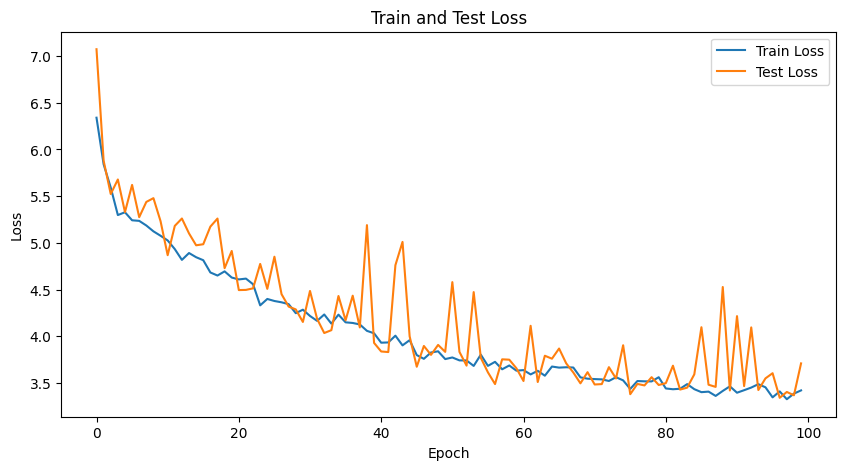

In [180]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Loss')
plt.legend()
plt.show()

In [183]:
data = read_dataset_folder(Folder_name)
data

,absolute angle of inclination,angle of inclination,number of electrodes,voltage magnitude,voltage frequency,electrode dimension,x pitch,number of phases,grain mass density,mesh size,gravity,phase shift,time step,maximum classified radius,distance between dust generation and first electrode,grain number density,yield
0,335.0,25.0,4.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.014511,1.0,3.738749
1,335.0,25.0,6.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.015185,1.0,2.602313
2,335.0,25.0,8.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.015858,1.0,2.719417
3,335.0,25.0,10.0,500.0,5.0,3.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.016532,1.0,1.865867
4,335.0,25.0,4.0,500.0,5.0,4.0,20.0,4.0,1000.0,0.001,3.0,90.0,0.005,0.00001,0.014011,1.0,6.512353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15848,50.0,50.0,4.0,2000.0,20.0,5.0,35.0,4.0,4000.0,0.001,12.0,90.0,0.005,0.00001,0.125134,1.0,1.085980
15849,50.0,50.0,6.0,2000.0,20.0,5.0,35.0,4.0,4000.0,0.001,12.0,90.0,0.005,0.00001,0.208557,1.0,0.112520
15850,50.0,50.0,8.0,2000.0,20.0,5.0,35.0,4.0,4000.0,0.001,12.0,90.0,0.005,0.00001,0.291980,1.0,0.014352
15851,50.0,50.0,10.0,2000.0,20.0,5.0,35.0,4.0,4000.0,0.001,12.0,90.0,0.005,0.00001,0.375402,1.0,0.003888


In [186]:
def predict_yield(model, input_data):
    model.eval()
    with torch.no_grad():
        input_tensor = torch.tensor(input_data, dtype=torch.float32).to(device)
        if input_tensor.dim() == 1:
            input_tensor = input_tensor.unsqueeze(0)
        output = model(input_tensor)
        prediction = output.cpu().numpy().flatten()  # Flatten the output
    return prediction

# Predict for all data points
all_inputs = data[numeric_features].values
all_predictions = predict_yield(model, all_inputs)

# Add predictions to your dataset
data['predicted_yield'] = all_predictions

# Filter and print results where predicted yield is >= 30
high_yield_data = data[data['predicted_yield'] >= 30]

print("Data points with predicted yield >= 30:")
for index, row in high_yield_data.iterrows():
    print(f"\nInput features:")
    for feature in numeric_features:
        print(f"{feature}: {row[feature]}")
    print(f"Actual yield: {row['yield']:.4f}")
    print(f"Predicted yield: {row['predicted_yield']:.4f}")  # Removed the [0] indexing
    print("-" * 50)

Data points with predicted yield >= 30:

Input features:
absolute angle of inclination: 335.0
number of electrodes: 4.0
electrode dimension: 5.0
x pitch: 20.0
distance between dust generation and first electrode: 0.013510771096
voltage magnitude: 2000.0
voltage frequency: 10.0
grain mass density: 4000.0
gravity: 3.0
Actual yield: 52.6253
Predicted yield: 30.9127
--------------------------------------------------

Input features:
absolute angle of inclination: 335.0
number of electrodes: 6.0
electrode dimension: 5.0
x pitch: 20.0
distance between dust generation and first electrode: 0.014184616506
voltage magnitude: 2000.0
voltage frequency: 10.0
grain mass density: 4000.0
gravity: 3.0
Actual yield: 47.5673
Predicted yield: 30.4468
--------------------------------------------------

Input features:
absolute angle of inclination: 335.0
number of electrodes: 4.0
electrode dimension: 6.0
x pitch: 20.0
distance between dust generation and first electrode: 0.013010770082
voltage magnitude: 2

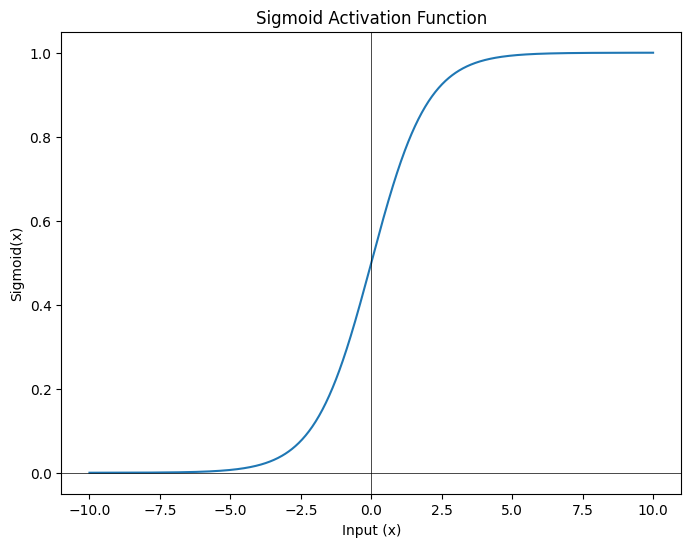

In [150]:
import torch
import matplotlib.pyplot as plt

# Create a tensor of input values
x = torch.linspace(-10, 10, 1000)

# Apply the sigmoid function
sigmoid = torch.nn.Sigmoid()
y = sigmoid(x)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(x.numpy(), y.numpy(), label="Sigmoid(x)")
plt.xlabel("Input (x)")
plt.ylabel("Sigmoid(x)")
plt.title("Sigmoid Activation Function")
#plt.grid(True)
#plt.legend()
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()
